In [196]:
import svgpathtools as spt
from svgpathtools import parse_path, Line, Path, wsvg, Arc
import numpy as np
import math

import tempfile, os
from IPython.display import SVG, display

import warnings

def disp_svg(paths):
    with tempfile.TemporaryDirectory() as tmp_dir:
        tmp_svg = os.path.join(tmp_dir, 'display.svg')
        svgpathtools.wsvg(paths, filename = tmp_svg)
        display(SVG(tmp_svg))

/var/folders/0p/j_4pkrn953x_vymtqt6kvnwm0000gn/T/ipykernel_12966/566675305.py:10: UserWarning: Warning...........Message
  warnings.warn("Warning...........Message")


In [9]:

def offset_curve(path, offset_distance, steps=1000):
    """Takes in a Path object, `path`, and a distance,
    `offset_distance`, and outputs an piecewise-linear approximation 
    of the 'parallel' offset curve."""
    nls = []
    for seg in path:
        ct = 1
        for k in range(steps):
            t = k / steps
            offset_vector = offset_distance * seg.normal(t)
            nl = Line(seg.point(t), seg.point(t) + offset_vector)
            nls.append(nl)
    connect_the_dots = [Line(nls[k].end, nls[k+1].end) for k in range(len(nls)-1)]
    if path.isclosed():
        connect_the_dots.append(Line(nls[-1].end, nls[0].end))
    offset_path = Path(*connect_the_dots)
    return offset_path

# Examples:
path1 = parse_path("m 288,600 c -52,-28 -42,-61 0,-97 ")
path2 = parse_path("M 151,395 C 407,485 726.17662,160 634,339").translated(300)
path3 = parse_path("m 117,695 c 237,-7 -103,-146 457,0").translated(500+400j)
paths = [path1, path2, path3]

offset_distances = [10*k for k in range(1,51)]
offset_paths = []
for path in paths:
    for distances in offset_distances:
        offset_paths.append(offset_curve(path, distances))

# Let's take a look
# wsvg(paths + offset_paths, 'g'*len(paths) + 'r'*len(offset_paths), filename='offset_curves.svg')
disvg(paths+ offset_paths) 

In [231]:

def get_cut_circle(radius, n_bridge, h_bridge, angle_bridge, sweep_angle_factor = 0):
    '''
        radius   :: Center radius of circle
        n_bridge :: Number of bridges
        h_bridge :: Height of the bridge/cut
        angle_bridge :: Angle the bridge subtends (results in w_bridge)
    '''
    if (n_bridge*angle_bridge > 360):
        warnings.warn("The amount of angle subtended by the bridges is larger than 360 degrees")
        
    h_cut = h_bridge
    radius_inner = (radius - h_cut/2)   +   (radius - h_cut/2)*1j ## ellipse, majorminor
    radius_outer = (radius + h_cut/2)   +   (radius + h_cut/2)*1j

    inter_angle = angle_bridge
    sweep_angle = 360/n_bridge - inter_angle

    w_bridge = radius*math.radians(inter_angle) ## note radius is center radius
    print(f'The resultant bridge is {w_bridge:.3g} thick at the current radius')
    # w_bridge = 
    # inter_angle = w_bridge*360/radius

    paths=[]
    for i in range(n_bridge):

        angle_offset = (sweep_angle+inter_angle)*sweep_angle_factor + i * inter_angle + i * sweep_angle

        radius = radius_inner
        x0_inner = radius.real
        x1_inner = radius.real*np.cos(math.radians(sweep_angle)) + radius.imag*np.sin(math.radians(sweep_angle))*1j

        radius = radius_outer
        x0_outer = radius.real
        x1_outer = radius.real*np.cos(math.radians(sweep_angle)) + radius.imag*np.sin(math.radians(sweep_angle))*1j

        arc_inner = Arc(x0_inner,radius_inner,0,large_arc=False,sweep=True,end=x1_inner)
        line_1    = Line(x1_inner,x1_outer)
        arc_outer = Arc(x1_outer,radius_outer,0,large_arc=False,sweep=False,end=x0_outer)
        line_0    = Line(x0_outer,x0_inner)


        path = Path(arc_inner, line_1, arc_outer, line_0)

        paths.append(path.rotated(angle_offset,origin=0))
    return paths


The resultant bridge is 0.0436 thick at the current radius
The resultant bridge is 0.08 thick at the current radius
The resultant bridge is 0.116 thick at the current radius
The resultant bridge is 0.153 thick at the current radius
The resultant bridge is 0.189 thick at the current radius
The resultant bridge is 0.225 thick at the current radius
The resultant bridge is 0.262 thick at the current radius


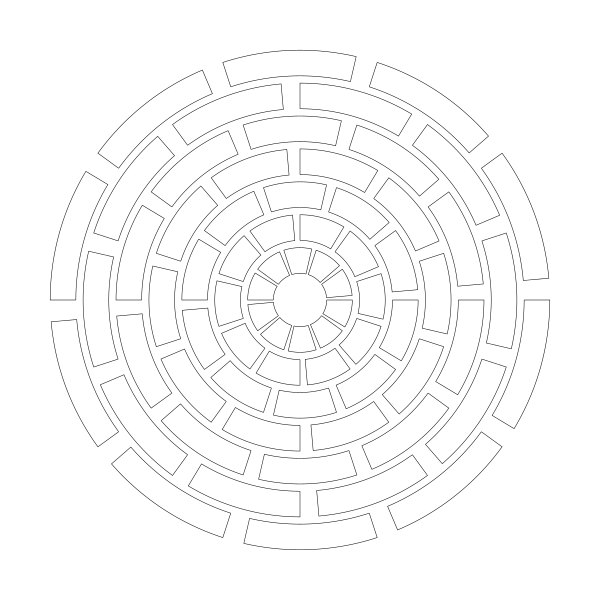

In [245]:
inner = 0.5
outer = 3
n_circles = 7
radii = np.linspace(inner,outer,n_circles)
circle_distance = (outer-inner)/n_circles

paths=[]
from itertools import cycle

lst = [0,0.5]
pool = cycle(lst)

for r in radii:
    paths+=(get_cut_circle(radius=r, n_bridge=10, angle_bridge=5, h_bridge=circle_distance/1.1, sweep_angle_factor=next(pool)))
disp_svg(paths)


In [88]:
## Obligatory art

for a in np.linspace(30,600,20):
    paths=get_cut_circle(radius=2, n_bridge=5, angle_bridge=a, h_bridge=0.15)
    disp_svg(paths)

In [246]:
disvg(paths)